# Disclaimer: in the real world we need clients consent before dropping or treating missing values, and before treating outliers. In other words, before manipulating the data in any way we need to ask client first.

# Problem Statement
Management of hyperglycemia in hospitalized patients has a significant bearing on outcome, in terms of both morbidity and mortality. However, there are few national assessments of diabetes care during hospitalization which could serve as a baseline for change. This analysis of a large clinical database was undertaken to provide such an assessment and to find future directions which might lead to improvements in patient safety.  
  
Based on the given data, build a model to predict whether the patient is suffering from Diabetes or not? 


## Importing all required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
df = pd.read_csv("dataset_diabetes_diabetic_data-1.csv")

## Checking the data

In [3]:
df.head()

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,change,diabatic
0,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,No,No
1,55629189,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,Ch,Yes
2,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,No,Yes
3,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,Ch,Yes
4,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,Ch,Yes


## Dropping unwanted variables

In [4]:
df.duplicated().sum()

0

In [5]:
df.shape[0]

70180

In [6]:
df['patient_nbr'].nunique()

52500

In [7]:
df.shape[0] - df['patient_nbr'].nunique()

17680

In [8]:
df.duplicated(subset = ['patient_nbr']).sum()

17680

In [9]:
df['patient_nbr'].value_counts()

1660293      23
23199021     23
23643405     22
84428613     22
89472402     20
             ..
21355677      1
96588117      1
61555455      1
9540666       1
175429310     1
Name: patient_nbr, Length: 52500, dtype: int64

In [10]:
df['patient_nbr'].value_counts()[df['patient_nbr'].value_counts() == 1].shape[0]

41923

In [11]:
df['patient_nbr'].value_counts()[df['patient_nbr'].value_counts() != 1].shape[0]

10577

In [12]:
df.drop_duplicates(subset = ['patient_nbr'], keep = 'last', inplace = True)

In [13]:
df.shape[0]

52500

In [14]:
df=df.drop(["patient_nbr"],axis=1) 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52500 entries, 0 to 70179
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      52500 non-null  object
 1   gender                    52500 non-null  object
 2   age                       52500 non-null  object
 3   admission_type_id         52500 non-null  int64 
 4   discharge_disposition_id  52500 non-null  int64 
 5   admission_source_id       52500 non-null  int64 
 6   time_in_hospital          52500 non-null  int64 
 7   num_lab_procedures        52500 non-null  int64 
 8   num_procedures            52500 non-null  int64 
 9   num_medications           52500 non-null  int64 
 10  number_outpatient         52500 non-null  int64 
 11  number_emergency          52500 non-null  int64 
 12  number_inpatient          52500 non-null  int64 
 13  diag_1                    52500 non-null  object
 14  diag_2                

diabatic is the target variable while all others are the predictors.  
  
Out of the 19 columns, 8 are object type, while remaining 11 are int.  
<b>Object</b> - race, gender, age, diag_1, diag_2, diag_3, change, diabatic  
<b>Int</b> -admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses
  
Since label encoding is already present in the data, some of the nominal variables are displayed as int.  
Actual Nominal variables are 12:
race, gender, age, admission_type_id, discharge_disposition_id, admission_source_id, diag_1, diag_2, diag_3, number_diagnoses, change, diabatic.
  
Actual Numeric variables are 7:
time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient

  
It appears there are also no missing values.

## Check for missing value in any column

In [16]:
# Are there any missing values ?
df.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
change                      0
diabatic                    0
dtype: int64

In [17]:
df['admission_type_id'].replace(5, np.nan, inplace = True)
df['admission_type_id'].replace(6, np.nan, inplace = True)
df['admission_type_id'].replace(8, np.nan, inplace = True)
df.isnull().sum()

race                           0
gender                         0
age                            0
admission_type_id           6645
discharge_disposition_id       0
admission_source_id            0
time_in_hospital               0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                         0
diag_2                         0
diag_3                         0
number_diagnoses               0
change                         0
diabatic                       0
dtype: int64

In [18]:
df['discharge_disposition_id'].replace(18, np.nan, inplace = True)
df['discharge_disposition_id'].replace(25, np.nan, inplace = True)
df['discharge_disposition_id'].replace(26, np.nan, inplace = True)
df.isnull().sum()

race                           0
gender                         0
age                            0
admission_type_id           6645
discharge_disposition_id    2942
admission_source_id            0
time_in_hospital               0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                         0
diag_2                         0
diag_3                         0
number_diagnoses               0
change                         0
diabatic                       0
dtype: int64

In [19]:
df['admission_source_id'].replace(9, np.nan, inplace = True)
df['admission_source_id'].replace(15, np.nan, inplace = True)
df['admission_source_id'].replace(17, np.nan, inplace = True)
df['admission_source_id'].replace(20, np.nan, inplace = True)
df['admission_source_id'].replace(21, np.nan, inplace = True)
df.isnull().sum()

race                           0
gender                         0
age                            0
admission_type_id           6645
discharge_disposition_id    2942
admission_source_id         4725
time_in_hospital               0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                         0
diag_2                         0
diag_3                         0
number_diagnoses               0
change                         0
diabatic                       0
dtype: int64

In [20]:
df[df.isnull().sum(axis = 1) != 0].shape[0]

9824

In [21]:
df[df.isnull().sum(axis = 1) == 1].shape[0]

5569

In [22]:
df[df.isnull().sum(axis = 1) == 2].shape[0]

4022

In [23]:
df[df.isnull().sum(axis = 1) == 3].shape[0]

233

In [24]:
df['admission_source_id'].isnull().sum()

4725

In [25]:
for i in df.columns:
    if df[i].isnull().sum() != 0:
        df[i].replace(np.nan, df[i].median(), inplace = True)

In [26]:
df.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
change                      0
diabatic                    0
dtype: int64

## Summary of the data

In [27]:
df.describe(include="all")

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,change,diabatic
count,52500,52500,52500,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500,52500,52500,52500.000000,52500,52500
unique,6,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,667,664,697,NaN,2,2
top,Caucasian,Female,[70-80),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,414,250,250,NaN,No,Yes
freq,38822,28175,13509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3861,3648,6646,NaN,33305,34193
mean,NaN,NaN,NaN,1.559200,2.772343,4.920667,4.341752,42.996171,1.398152,15.192629,0.280019,0.124819,0.476610,NaN,NaN,NaN,7.089352,NaN,NaN
std,NaN,NaN,NaN,0.783978,3.843406,2.727106,3.015526,19.347772,1.713572,8.201336,1.034855,0.660930,1.020395,NaN,NaN,NaN,2.018542,NaN,NaN
min,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,5.000000,NaN,NaN
50%,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,NaN,NaN
75%,NaN,NaN,NaN,2.000000,3.000000,7.000000,6.000000,56.000000,2.000000,19.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN


In [28]:
df.head(10)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,change,diabatic
0,Caucasian,Female,[0-10),1.0,1.0,1.0,1,41,0,1,0,0,0,250.83,?,?,1,No,No
1,Caucasian,Female,[10-20),1.0,1.0,7.0,3,59,0,18,0,0,0,276,250.01,255,9,Ch,Yes
2,AfricanAmerican,Female,[20-30),1.0,1.0,7.0,2,11,5,13,2,0,1,648,250,V27,6,No,Yes
3,Caucasian,Male,[30-40),1.0,1.0,7.0,2,44,1,16,0,0,0,8,250.43,403,7,Ch,Yes
4,Caucasian,Male,[40-50),1.0,1.0,7.0,1,51,0,8,0,0,0,197,157,250,5,Ch,Yes
5,Caucasian,Male,[50-60),2.0,1.0,2.0,3,31,6,16,0,0,0,414,411,250,9,No,Yes
6,Caucasian,Male,[60-70),3.0,1.0,2.0,4,70,1,21,0,0,0,414,411,V45,7,Ch,Yes
7,Caucasian,Male,[70-80),1.0,1.0,7.0,5,73,0,12,0,0,0,428,492,250,8,No,Yes
8,Caucasian,Female,[80-90),2.0,1.0,4.0,13,68,2,28,0,0,0,398,427,38,8,Ch,Yes
9,Caucasian,Female,[90-100),3.0,3.0,4.0,12,33,3,18,0,0,0,434,198,486,8,Ch,Yes


In [29]:
#import pandas_profiling
#profile = df.profile_report(title='Report on patient data')
#profile.to_file(output_file="E2E Patient Data.html")

Some variables has invalid character "?"

## Geting unique counts of all Nominal Variables

In [30]:
for column in df[['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                   'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'change', 'diabatic']]:
    print(column.upper(),': ',df[column].nunique())
    print(df[column].value_counts().sort_values())
    print('\n')

RACE :  6
Asian                314
Other                718
Hispanic            1013
?                   1247
AfricanAmerican    10386
Caucasian          38822
Name: race, dtype: int64


GENDER :  3
Unknown/Invalid        2
Male               24323
Female             28175
Name: gender, dtype: int64


AGE :  10
[0-10)        149
[10-20)       432
[20-30)       820
[90-100)     1451
[30-40)      2018
[40-50)      5055
[80-90)      8489
[50-60)      9141
[60-70)     11436
[70-80)     13509
Name: age, dtype: int64


ADMISSION_TYPE_ID :  5
4.0        7
7.0        7
3.0     9537
2.0    10221
1.0    32728
Name: admission_type_id, dtype: int64


DISCHARGE_DISPOSITION_ID :  24
27.0        2
12.0        2
20.0        2
19.0        5
16.0        5
10.0        6
9.0         8
17.0       11
24.0       14
15.0       22
28.0       51
8.0        71
13.0      213
14.0      213
23.0      217
7.0       310
4.0       510
5.0       734
22.0      868
2.0      1134
11.0     1254
6.0      5824
3.0      6263


race, diag1, diag2 and diag3 has ?

diag1, diag2, diag3 — are categorical and have a lot of values. We will remove these and use number_diagnoses to capture some of this information.

In [31]:
print('Before Removing: ',df.shape)
df=df.drop(["diag_1","diag_2","diag_3"],axis=1) 
print('After Removing: ',df.shape)

Before Removing:  (52500, 19)
After Removing:  (52500, 16)


This leaves us with 1461 values in race variable that has ?  
Since this is a categorical variable, we can either have these as a separate group, or we will remove them, since we still have sufficient data

In [32]:
print('Before: ',df.shape)
# Replace ? to Nan and remove all missing values
df.race = df.race.replace(to_replace = '?', value =np.nan)
df.dropna(inplace=True)
print('After: ',df.shape)

Before:  (52500, 16)
After:  (51253, 16)


## Check for duplicate data

In [33]:
# Are there any duplicates ?
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
df[dups]

Number of duplicate rows = 28


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabatic
4722,AfricanAmerican,Female,[10-20),1.0,1.0,7.0,3,51,0,3,0,0,0,1,No,Yes
16811,Caucasian,Female,[60-70),1.0,1.0,7.0,3,39,0,11,0,0,0,5,No,Yes
17298,Caucasian,Female,[20-30),3.0,1.0,1.0,3,22,1,15,0,0,0,7,No,No
19767,Caucasian,Male,[80-90),1.0,3.0,7.0,4,22,0,12,0,0,0,9,Ch,Yes
20513,Caucasian,Male,[60-70),1.0,1.0,7.0,2,42,3,15,0,0,0,6,No,Yes
23932,AfricanAmerican,Female,[50-60),1.0,1.0,7.0,2,34,0,8,0,0,0,4,No,Yes
24690,Caucasian,Male,[70-80),1.0,1.0,7.0,3,59,0,8,0,0,0,7,No,Yes
29525,Caucasian,Male,[40-50),1.0,1.0,7.0,1,35,5,13,0,0,0,8,Ch,Yes
34892,AfricanAmerican,Female,[50-60),1.0,1.0,7.0,1,46,0,10,0,0,0,6,No,Yes
41130,Caucasian,Female,[50-60),1.0,1.0,7.0,1,41,0,8,0,0,0,5,Ch,Yes


## Checking for Outliers

<AxesSubplot:>

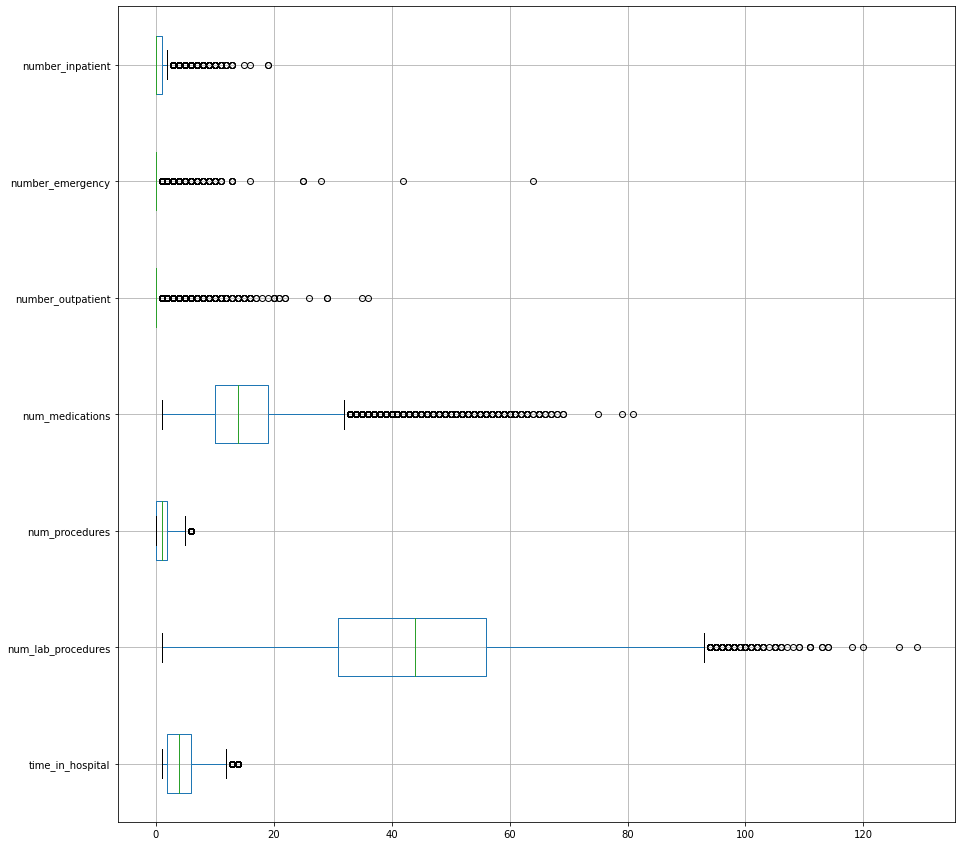

In [34]:
# construct box plot for continuous variables
plt.figure(figsize=(15,15))
df[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']].boxplot(vert=0)

In [35]:
def replace_outlier(col):
    Q1, Q3 = np.quantile(col, [.25, .75])
    IQR = Q3 - Q1
    LL = Q1 - 1.5*IQR
    UL = Q3 + 1.5*IQR
    return LL, UL

In [36]:
df_num = df[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']]

In [37]:
for i in df_num.columns:
    LL, UL = replace_outlier(df_num[i])
    df_num[i] = np.where(df_num[i]> UL, UL, df_num[i])
    df_num[i] = np.where(df_num[i]< LL, LL, df_num[i])

<AxesSubplot:>

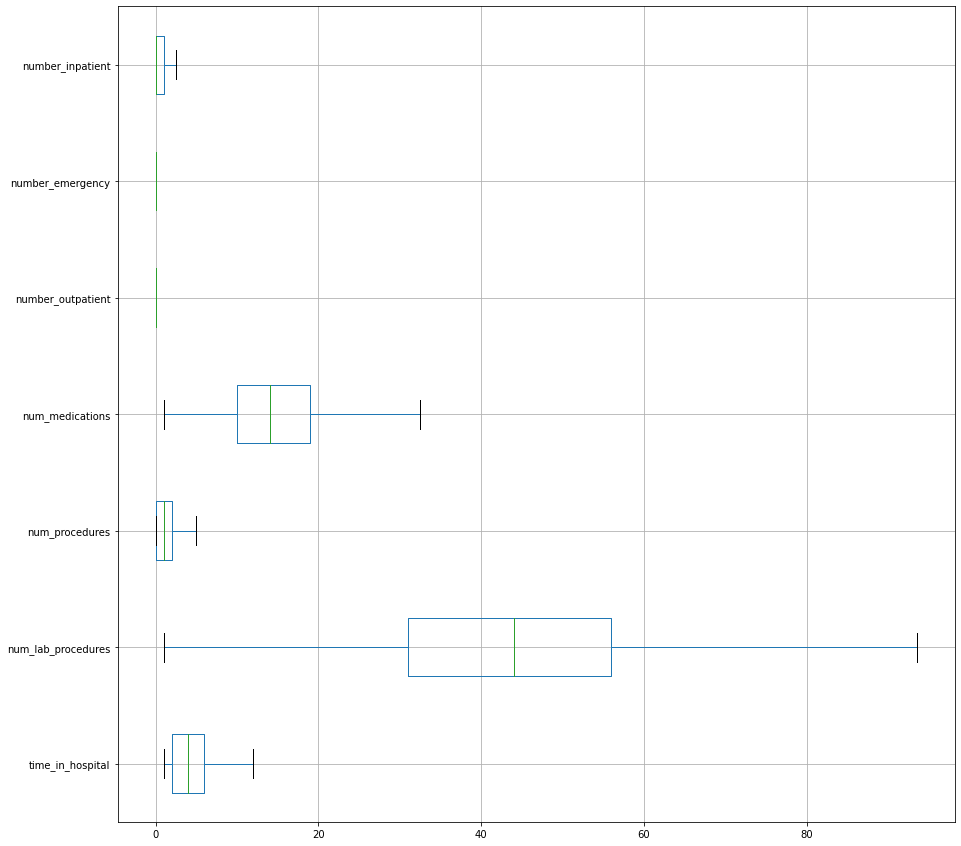

In [38]:
plt.figure(figsize=(15,15))
df_num.boxplot(vert=0)

## Checking pairwise distribution of the continuous variables

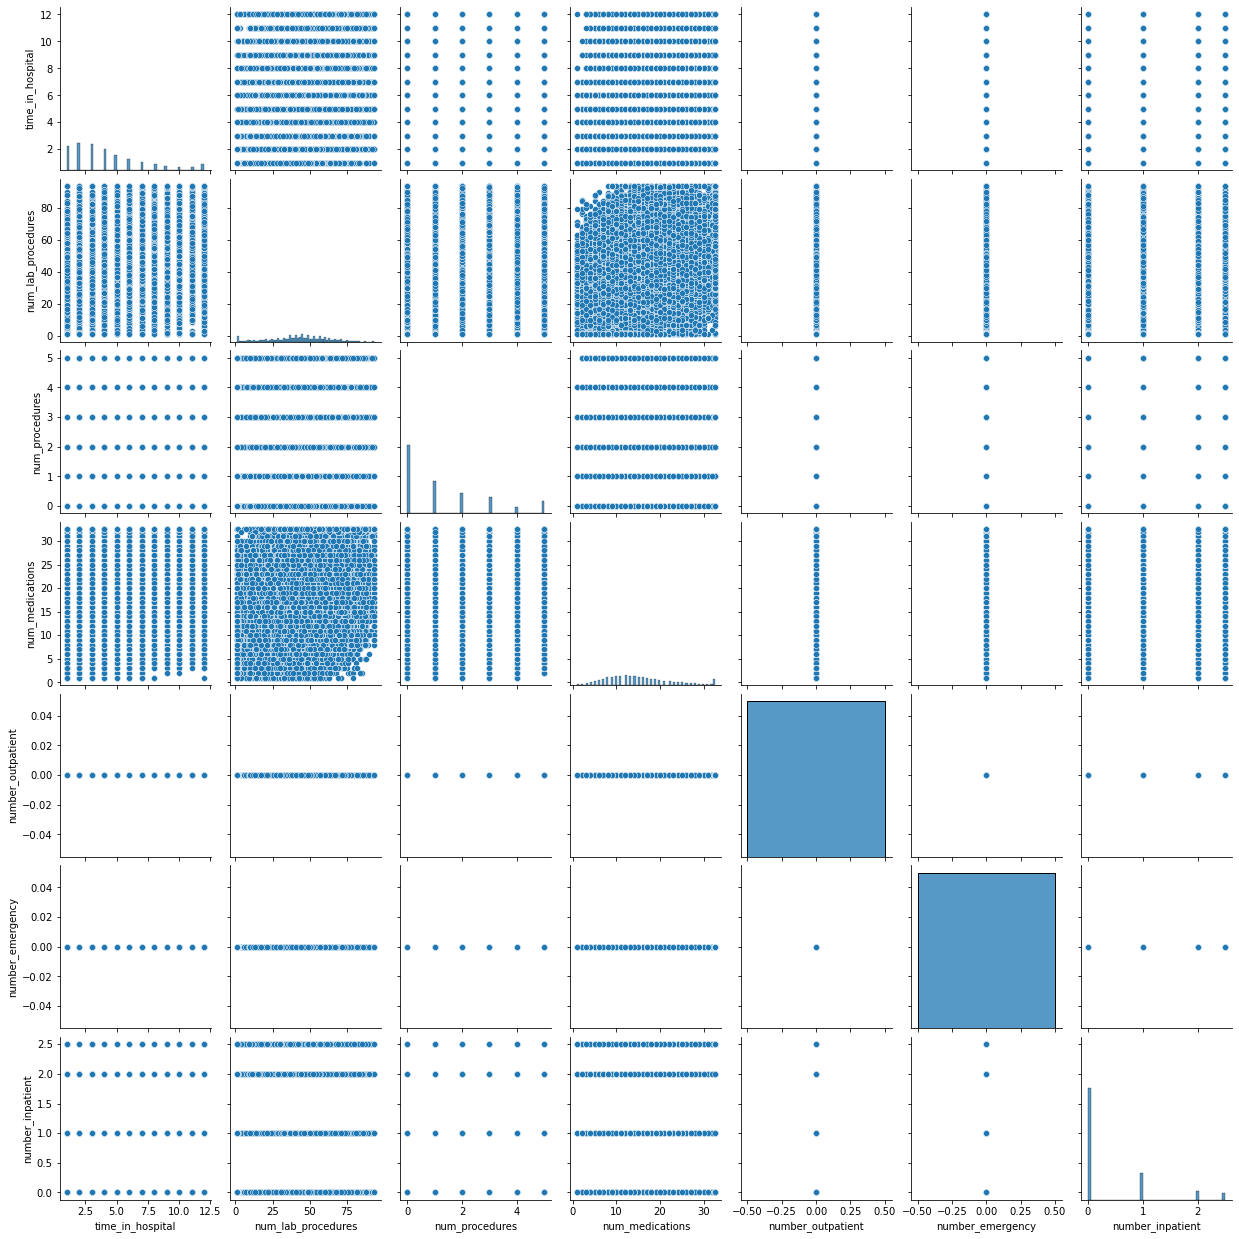

In [39]:
sns.pairplot(df_num)

## Checking for Correlations

<AxesSubplot:>

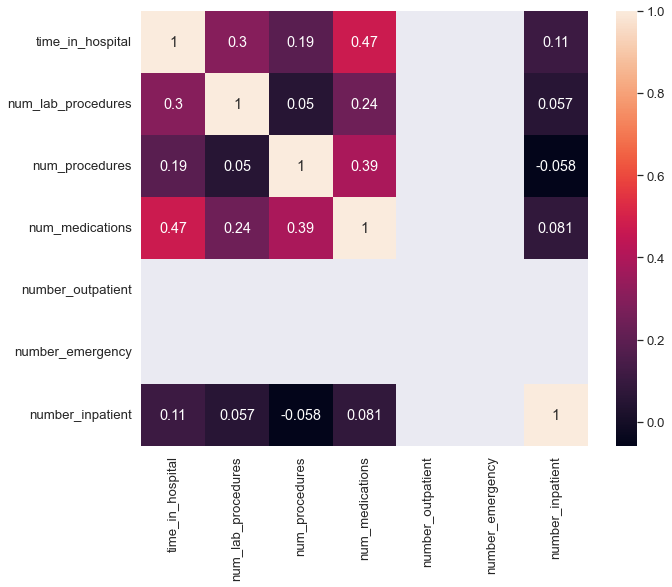

In [40]:
# construct heatmap with only continuous variables
plt.figure(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(df_num.corr(), annot=True)

There are mostly positive correlations between variables, and very few negative correlations.  
Overall the magnitude of correlations between the variables are very less.

## Converting all objects to categorical codes

In [41]:
for feature in df.columns: 
    if df[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(df[feature].unique()))
        print(pd.Categorical(df[feature].unique()).codes)
        df[feature] = pd.Categorical(df[feature]).codes



feature: race
['Caucasian', 'AfricanAmerican', 'Other', 'Asian', 'Hispanic']
Categories (5, object): ['AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other']
[2 0 4 1 3]


feature: gender
['Female', 'Male', 'Unknown/Invalid']
Categories (3, object): ['Female', 'Male', 'Unknown/Invalid']
[0 1 2]


feature: age
['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
Categories (10, object): ['[0-10)', '[10-20)', '[20-30)', '[30-40)', ..., '[60-70)', '[70-80)', '[80-90)', '[90-100)']
[0 1 2 3 4 5 6 7 8 9]


feature: change
['No', 'Ch']
Categories (2, object): ['Ch', 'No']
[1 0]


feature: diabatic
['No', 'Yes']
Categories (2, object): ['No', 'Yes']
[0 1]


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51253 entries, 0 to 70179
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   race                      51253 non-null  int8   
 1   gender                    51253 non-null  int8   
 2   age                       51253 non-null  int8   
 3   admission_type_id         51253 non-null  float64
 4   discharge_disposition_id  51253 non-null  float64
 5   admission_source_id       51253 non-null  float64
 6   time_in_hospital          51253 non-null  int64  
 7   num_lab_procedures        51253 non-null  int64  
 8   num_procedures            51253 non-null  int64  
 9   num_medications           51253 non-null  int64  
 10  number_outpatient         51253 non-null  int64  
 11  number_emergency          51253 non-null  int64  
 12  number_inpatient          51253 non-null  int64  
 13  number_diagnoses          51253 non-null  int64  
 14  change

In [43]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabatic
0,2,0,0,1.0,1.0,1.0,1,41,0,1,0,0,0,1,1,0
1,2,0,1,1.0,1.0,7.0,3,59,0,18,0,0,0,9,0,1
2,0,0,2,1.0,1.0,7.0,2,11,5,13,2,0,1,6,1,1
3,2,1,3,1.0,1.0,7.0,2,44,1,16,0,0,0,7,0,1
4,2,1,4,1.0,1.0,7.0,1,51,0,8,0,0,0,5,0,1


## Proportion of 1s and 0s

In [44]:
df.diabatic.value_counts(normalize=True)

1    0.649796
0    0.350204
Name: diabatic, dtype: float64

There is no issue of class imbalance here as we have reasonable proportions in both the classes

## Extracting the target column into separate vectors for training set and test set

In [45]:
X = df.drop("diabatic", axis=1)

y = df["diabatic"]

X.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change
0,2,0,0,1.0,1.0,1.0,1,41,0,1,0,0,0,1,1
1,2,0,1,1.0,1.0,7.0,3,59,0,18,0,0,0,9,0
2,0,0,2,1.0,1.0,7.0,2,11,5,13,2,0,1,6,1
3,2,1,3,1.0,1.0,7.0,2,44,1,16,0,0,0,7,0
4,2,1,4,1.0,1.0,7.0,1,51,0,8,0,0,0,5,0


## Splitting data into training and test set

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=1, stratify = y)

## Checking the dimensions of the training and test data

In [47]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('train_labels',train_labels.shape)
print('test_labels',test_labels.shape)

X_train (35877, 15)
X_test (15376, 15)
train_labels (35877,)
test_labels (15376,)


# Building a Decision Tree Classifier

In [48]:
param_grid = {
    'criterion': ['gini'],
    'max_depth': [10,20,30,50],# 3,5,7,9
    'min_samples_leaf': [50,100,150], # 1-3% 50-150
    'min_samples_split': [450,150,300] # 150 - 450
}

dtcl = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtcl, param_grid = param_grid, cv = 10)

In [49]:
grid_search.fit(X_train, train_labels)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
best_grid
#{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 450}

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 150, 'min_samples_split': 150}


DecisionTreeClassifier(max_depth=10, min_samples_leaf=150,
                       min_samples_split=150)

## Generating Tree

In [50]:
train_char_label = ['no', 'yes']
tree_regularized = open('tree_regularized.dot','w')
dot_data = tree.export_graphviz(best_grid, out_file= tree_regularized , feature_names = list(X_train), class_names = list(train_char_label))

tree_regularized.close()
dot_data

In [51]:
# from sklearn.tree import export_graphviz
# from io import StringIO  
# from IPython.display import Image  
# import pydotplus
# import graphviz


# dtc_new = DecisionTreeClassifier(criterion = 'entropy', max_depth=5)
# dtc_new.fit(X_train, train_labels)

# dot_data = StringIO()
# export_graphviz(dtc_new, out_file=dot_data, filled  = True, rounded = True, feature_names=X_train.columns)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('tree.png')
# Image(graph.create_png())

http://webgraphviz.com/

## Variable Importance

In [52]:
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                               Imp
change                    0.872788
num_medications           0.039682
number_diagnoses          0.029912
age                       0.013948
num_procedures            0.010609
num_lab_procedures        0.007787
admission_type_id         0.007473
admission_source_id       0.006137
time_in_hospital          0.004812
gender                    0.001944
discharge_disposition_id  0.001594
race                      0.001439
number_outpatient         0.000959
number_inpatient          0.000914
number_emergency          0.000000


## Predicting on Training and Test dataset

In [53]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

## Getting the Predicted Classes and Probs

In [54]:
ytest_predict
ytest_predict_prob=best_grid.predict_proba(X_test)
ytest_predict_prob
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.000000,1.000000
1,0.780488,0.219512
2,0.560000,0.440000
3,0.570175,0.429825
4,0.210744,0.789256


## Model Evaluation

### AUC and ROC for the training data

AUC: 0.844


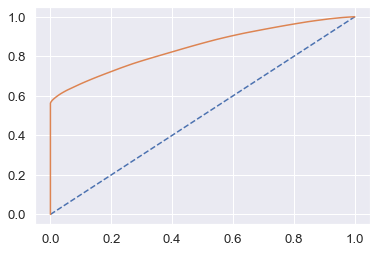

In [55]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_train_auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % cart_train_auc)
# calculate roc curve
cart_train_fpr, cart_train_tpr, cart_train_thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_train_fpr, cart_train_tpr)

### AUC and ROC for the test data

AUC: 0.831


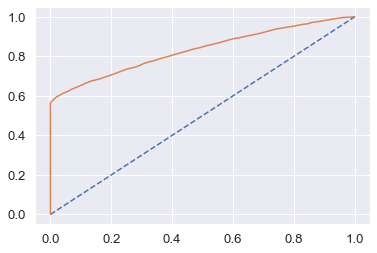

In [56]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
cart_test_auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % cart_test_auc)
# calculate roc curve
cart_test_fpr, cart_test_tpr, cart_testthresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(cart_test_fpr, cart_test_tpr)

### Confusion Matrix for the training data

In [57]:
confusion_matrix(train_labels, ytrain_predict)

array([[ 9319,  3245],
       [ 5693, 17620]], dtype=int64)

In [58]:
#Train Data Accuracy
cart_train_acc=best_grid.score(X_train,train_labels) 
cart_train_acc

0.7508710315801209

In [59]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.62      0.74      0.68     12564
           1       0.84      0.76      0.80     23313

    accuracy                           0.75     35877
   macro avg       0.73      0.75      0.74     35877
weighted avg       0.77      0.75      0.76     35877



In [60]:
cart_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_train_precision=round(df.loc["1"][0],2)
cart_train_recall=round(df.loc["1"][1],2)
cart_train_f1=round(df.loc["1"][2],2)
print ('cart_train_precision ',cart_train_precision)
print ('cart_train_recall ',cart_train_recall)
print ('cart_train_f1 ',cart_train_f1)

cart_train_precision  0.84
cart_train_recall  0.76
cart_train_f1  0.8


### Confusion Matrix for test data

In [61]:
confusion_matrix(test_labels, ytest_predict)

array([[3851, 1534],
       [2517, 7474]], dtype=int64)

In [62]:
#Test Data Accuracy
cart_test_acc=best_grid.score(X_test,test_labels)
cart_test_acc

0.7365374609781478

In [63]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

           0       0.60      0.72      0.66      5385
           1       0.83      0.75      0.79      9991

    accuracy                           0.74     15376
   macro avg       0.72      0.73      0.72     15376
weighted avg       0.75      0.74      0.74     15376



In [64]:
cart_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(cart_metrics).transpose()
cart_test_precision=round(df.loc["1"][0],2)
cart_test_recall=round(df.loc["1"][1],2)
cart_test_f1=round(df.loc["1"][2],2)
print ('cart_train_precision ',cart_test_precision)
print ('cart_train_recall ',cart_test_recall)
print ('cart_train_f1 ',cart_test_f1)

cart_train_precision  0.83
cart_train_recall  0.75
cart_train_f1  0.79


# Cart Conclusion

<b>Train Data:</b>  
    AUC: 84.7%        
    Accuracy: 75.5%        
    Sensitivity: 78%     
    Precision: 84%        
    f1-Score: 81%       
            
<b>Test Data:</b>      
    AUC: 83.5%      
    Accuracy:74.4%      
    Sensitivity: 77%    
    Precision: 83%       
    f1-Score: 80%     
  
Training and Test set results are almost similar, and with the overall measures high, the model is a good model.  
  
Change is the most important variable for predicting diabetes

# Building a Random Forest Classifier

### Grid Search for finding out the optimal values for the hyper parameters

Due to large volume of data, trying for different parameter values in the gridsearch with higher cv value will lead to performance issues and model will run for much longer time

In [65]:
param_grid = {
    'max_depth': [10],
    'max_features': [6],
    'min_samples_leaf': [10],
    'min_samples_split': [50],
    'n_estimators': [300]
}

rfcl = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 5)

In [66]:
grid_search.fit(X_train, train_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10], 'max_features': [6],
                         'min_samples_leaf': [10], 'min_samples_split': [50],
                         'n_estimators': [300]})

In [67]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 50,
 'n_estimators': 300}

In [68]:
best_grid = grid_search.best_estimator_

In [69]:
best_grid

RandomForestClassifier(max_depth=10, max_features=6, min_samples_leaf=10,
                       min_samples_split=50, n_estimators=300)

## Predicting the Training and Testing data

In [70]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

## RF Model Performance Evaluation on Training data

In [71]:
confusion_matrix(train_labels,ytrain_predict)

array([[10492,  2072],
       [ 6083, 17230]], dtype=int64)

In [72]:
rf_train_acc=best_grid.score(X_train,train_labels) 
rf_train_acc

0.772695598851632

In [73]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

           0       0.63      0.84      0.72     12564
           1       0.89      0.74      0.81     23313

    accuracy                           0.77     35877
   macro avg       0.76      0.79      0.76     35877
weighted avg       0.80      0.77      0.78     35877



In [74]:
rf_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_train_precision=round(df.loc["1"][0],2)
rf_train_recall=round(df.loc["1"][1],2)
rf_train_f1=round(df.loc["1"][2],2)
print ('rf_train_precision ',rf_train_precision)
print ('rf_train_recall ',rf_train_recall)
print ('rf_train_f1 ',rf_train_f1)

rf_train_precision  0.89
rf_train_recall  0.74
rf_train_f1  0.81


Area under Curve is 0.7870784942310145


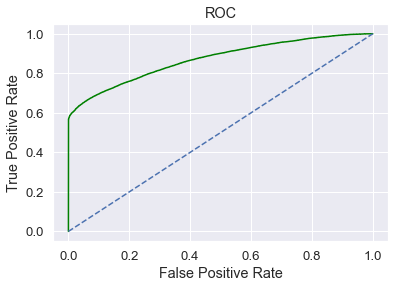

In [75]:
rf_train_fpr, rf_train_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.plot(rf_train_fpr,rf_train_tpr,color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_train_auc=roc_auc_score(train_labels,best_grid.predict(X_train))
print('Area under Curve is', rf_train_auc)

## RF Model Performance Evaluation on Test data

In [76]:
confusion_matrix(test_labels,ytest_predict)

array([[4311, 1074],
       [2780, 7211]], dtype=int64)

In [77]:
rf_test_acc=best_grid.score(X_test,test_labels)
rf_test_acc

0.7493496357960457

In [78]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

           0       0.61      0.80      0.69      5385
           1       0.87      0.72      0.79      9991

    accuracy                           0.75     15376
   macro avg       0.74      0.76      0.74     15376
weighted avg       0.78      0.75      0.75     15376



In [79]:
rf_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(rf_metrics).transpose()
rf_test_precision=round(df.loc["1"][0],2)
rf_test_recall=round(df.loc["1"][1],2)
rf_test_f1=round(df.loc["1"][2],2)
print ('rf_test_precision ',rf_test_precision)
print ('rf_test_recall ',rf_test_recall)
print ('rf_test_f1 ',rf_test_f1)

rf_test_precision  0.87
rf_test_recall  0.72
rf_test_f1  0.79


Area under Curve is 0.7611533388406111


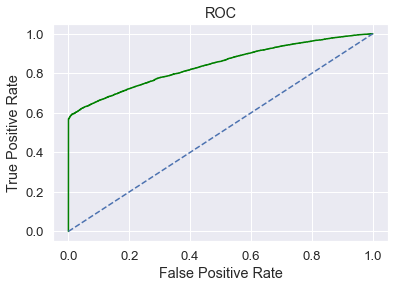

In [80]:
rf_test_fpr, rf_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(rf_test_fpr,rf_test_tpr,color='green')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
rf_test_auc=roc_auc_score(test_labels,best_grid.predict(X_test))
print('Area under Curve is', rf_test_auc)

In [81]:
# Variable Importance
print (pd.DataFrame(best_grid.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                               Imp
change                    0.789602
num_medications           0.066731
number_diagnoses          0.032695
num_lab_procedures        0.020853
age                       0.017729
time_in_hospital          0.017146
num_procedures            0.013450
admission_source_id       0.009010
admission_type_id         0.007179
discharge_disposition_id  0.006312
race                      0.005770
number_inpatient          0.004861
number_outpatient         0.003809
gender                    0.003110
number_emergency          0.001745


# Random Forest Conclusion

# Building a Neural Network Classifier

In [82]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [83]:
param_grid = {
    'hidden_layer_sizes': [100], #,50,200(200,200) 
    'max_iter': [7000], #5000,2500
    'solver': ['adam'], #sgd
    'tol': [0.01], 
}

nncl = MLPClassifier()

grid_search = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 10)

In [84]:
grid_search.fit(X_train_scaled, train_labels)
grid_search.best_params_
#{'hidden_layer_sizes': 100, 'max_iter': 7000, 'solver': 'adam', 'tol': 0.01}

{'hidden_layer_sizes': 100, 'max_iter': 7000, 'solver': 'adam', 'tol': 0.01}

In [85]:
best_grid = grid_search.best_estimator_
best_grid

MLPClassifier(hidden_layer_sizes=100, max_iter=7000, tol=0.01)

## Predicting the Training and Testing data

In [86]:
ytrain_predict = best_grid.predict(X_train_scaled)
ytest_predict = best_grid.predict(X_test_scaled)

## NN Model Performance Evaluation on Training data

In [87]:
confusion_matrix(train_labels,ytrain_predict)

array([[10194,  2370],
       [ 6497, 16816]], dtype=int64)

In [88]:
nn_train_acc=best_grid.score(X_train_scaled,train_labels) 
nn_train_acc

0.7528500153301558

In [89]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

           0       0.61      0.81      0.70     12564
           1       0.88      0.72      0.79     23313

    accuracy                           0.75     35877
   macro avg       0.74      0.77      0.74     35877
weighted avg       0.78      0.75      0.76     35877



In [90]:
nn_metrics=classification_report(train_labels, ytrain_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_train_precision=round(df.loc["1"][0],2)
nn_train_recall=round(df.loc["1"][1],2)
nn_train_f1=round(df.loc["1"][2],2)
print ('nn_train_precision ',nn_train_precision)
print ('nn_train_recall ',nn_train_recall)
print ('nn_train_f1 ',nn_train_f1)

nn_train_precision  0.88
nn_train_recall  0.72
nn_train_f1  0.79


Area under Curve is 0.5298050970409703


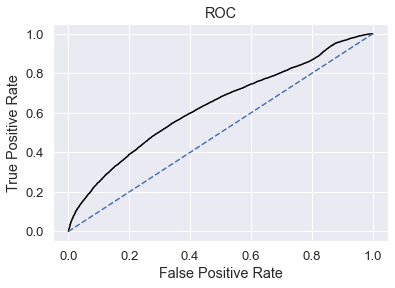

In [91]:
nn_train_fpr, nn_train_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.plot(nn_train_fpr,nn_train_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_train_auc=roc_auc_score(train_labels,best_grid.predict(X_train))
print('Area under Curve is', nn_train_auc)

## NN Model Performance Evaluation on Test data

In [92]:
confusion_matrix(test_labels,ytest_predict)

array([[4287, 1098],
       [2878, 7113]], dtype=int64)

In [93]:
nn_test_acc=best_grid.score(X_test_scaled,test_labels)
nn_test_acc

0.7414151925078044

In [94]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

           0       0.60      0.80      0.68      5385
           1       0.87      0.71      0.78      9991

    accuracy                           0.74     15376
   macro avg       0.73      0.75      0.73     15376
weighted avg       0.77      0.74      0.75     15376



In [95]:
nn_metrics=classification_report(test_labels, ytest_predict,output_dict=True)
df=pd.DataFrame(nn_metrics).transpose()
nn_test_precision=round(df.loc["1"][0],2)
nn_test_recall=round(df.loc["1"][1],2)
nn_test_f1=round(df.loc["1"][2],2)
print ('nn_test_precision ',nn_test_precision)
print ('nn_test_recall ',nn_test_recall)
print ('nn_test_f1 ',nn_test_f1)

nn_test_precision  0.87
nn_test_recall  0.71
nn_test_f1  0.78


Area under Curve is 0.5284735649270973


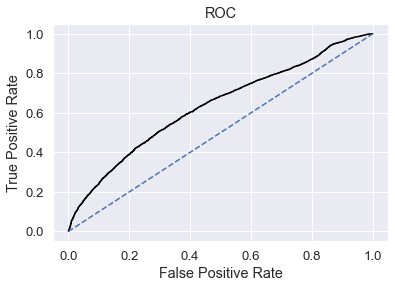

In [96]:
nn_test_fpr, nn_test_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.plot(nn_test_fpr,nn_test_tpr,color='black')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
nn_test_auc=roc_auc_score(test_labels,best_grid.predict(X_test))
print('Area under Curve is', nn_test_auc)

In [97]:
best_grid.score

<bound method ClassifierMixin.score of MLPClassifier(hidden_layer_sizes=100, max_iter=7000, tol=0.01)>

# Neural Network Conclusion

# Final Conclusion

## Comparison of the performance metrics from the 3 models

In [98]:
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data = pd.DataFrame({'CART Train':[cart_train_acc,cart_train_auc,cart_train_recall,cart_train_precision,cart_train_f1],
        'CART Test':[cart_test_acc,cart_test_auc,cart_test_recall,cart_test_precision,cart_test_f1],
       'Random Forest Train':[rf_train_acc,rf_train_auc,rf_train_recall,rf_train_precision,rf_train_f1],
        'Random Forest Test':[rf_test_acc,rf_test_auc,rf_test_recall,rf_test_precision,rf_test_f1],
       'Neural Network Train':[nn_train_acc,nn_train_auc,nn_train_recall,nn_train_precision,nn_train_f1],
        'Neural Network Test':[nn_test_acc,nn_test_auc,nn_test_recall,nn_test_precision,nn_test_f1]},index=index)
round(data,2)

,CART Train,CART Test,Random Forest Train,Random Forest Test,Neural Network Train,Neural Network Test
Accuracy,0.75,0.74,0.77,0.75,0.75,0.74
AUC,0.84,0.83,0.79,0.76,0.53,0.53
Recall,0.76,0.75,0.74,0.72,0.72,0.71
Precision,0.84,0.83,0.89,0.87,0.88,0.87
F1 Score,0.80,0.79,0.81,0.79,0.79,0.78


## ROC Curve for the 3 models on the Training data

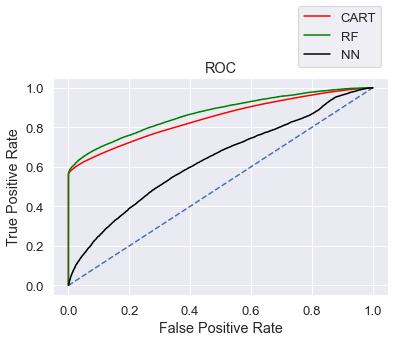

In [99]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_train_fpr, cart_train_tpr,color='red',label="CART")
plt.plot(rf_train_fpr,rf_train_tpr,color='green',label="RF")
plt.plot(nn_train_fpr,nn_train_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')

## ROC Curve for the 3 models on the Test data

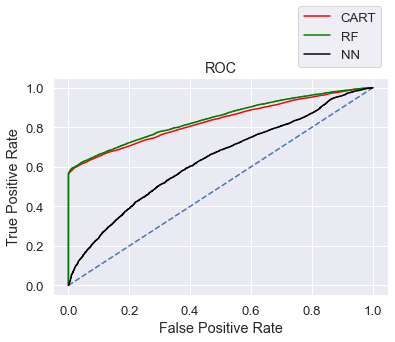

In [100]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(cart_test_fpr, cart_test_tpr,color='red',label="CART")
plt.plot(rf_test_fpr,rf_test_tpr,color='green',label="RF")
plt.plot(nn_test_fpr,nn_test_tpr,color='black',label="NN")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')